In [13]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pickle
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [14]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred): 
    return np.sqrt(mean_squared_error(y_true, y_pred))

def show_errors(y_true, y_pred):
    return pd.DataFrame({'RMSE': root_mean_squared_error(y_true,y_pred),\
                                            'MAE':mean_absolute_error(y_true,y_pred),\
                                            'MAPE': mean_absolute_percentage_error(y_true,y_pred)}, index=[0])

In [15]:
genre_groups = pickle.load(open('data/genre_groups.pkl', "rb"))
genre_groups

,date,predicted_genre,OPM
0,2017-01-01,opm acoustic,24
1,2017-01-01,opm jazz,2
2,2017-01-01,opm rap,4
3,2017-01-01,opm rock,6
4,2017-01-02,opm acoustic,25
...,...,...,...
8991,2022-09-14,opm rock,28
8992,2022-09-15,opm acoustic,33
8993,2022-09-15,opm jazz,3
8994,2022-09-15,opm rap,8


In [16]:
genre_groups.groupby(['predicted_genre'])[["OPM"]].sum().sort_values(by='OPM',ascending=False)
#.predicted_genre.value_counts(normalize=True)

,OPM
predicted_genre,
opm acoustic,60276
opm rock,47948
opm rap,14215
opm jazz,7651
opm dance,657
opm reggae,119


In [17]:
spec_genre="opm rock"

data=genre_groups[genre_groups.predicted_genre==spec_genre]
#data.date.values.min(),data.date.values.max()
data.set_index("date",inplace=True)
data.columns=["predicted_genre","streams"]
data

,predicted_genre,streams
date,,
2017-01-01,opm rock,6
2017-01-02,opm rock,7
2017-01-03,opm rock,6
2017-01-04,opm rock,6
2017-01-05,opm rock,6
...,...,...
2022-09-11,opm rock,30
2022-09-12,opm rock,29
2022-09-13,opm rock,28


# Setup

Text(0, 0.5, 'Streams')

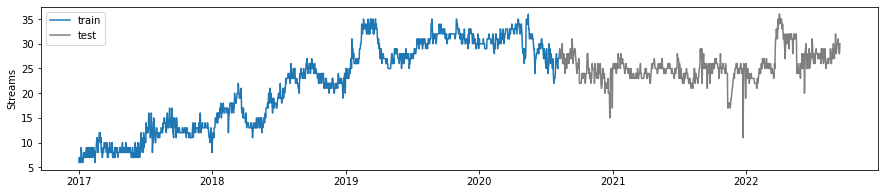

In [18]:
#split dataset to training and test sets

train_start_date_range='2017-01-01'
train_end_date_range='2020-08-08'
test_start_data_range='2020-08-08'
test_end_data_range='2022-09-15'


# train_start_date_range='2017-01-01'
# train_end_date_range='2021-05-11'
# test_start_data_range='2021-05-11'
# test_end_data_range='2022-09-15'


train_df = data[train_start_date_range:train_end_date_range]
test_df = data[test_start_data_range:test_end_data_range]

fig = plt.figure(figsize=(15,3))
plt.plot(train_df['streams'], color='C0', label='train')
plt.plot(test_df['streams'], color='C7', label='test')
plt.legend()
plt.ylabel("Streams")



### 2.1. Previous value (Naive) Approach
The simplest forecast--the previous available value is the forecast value.

In [19]:
# To simulate a naive forecast that takes in incoming data from test set
# shift the data 1 day to the right
forecast_df = data.shift(1)[test_start_data_range:test_end_data_range]
forecast_df

,predicted_genre,streams
date,,
2020-08-08,opm rock,27.0
2020-08-09,opm rock,28.0
2020-08-10,opm rock,29.0
2020-08-11,opm rock,27.0
2020-08-12,opm rock,27.0
...,...,...
2022-09-11,opm rock,31.0
2022-09-12,opm rock,30.0
2022-09-13,opm rock,29.0


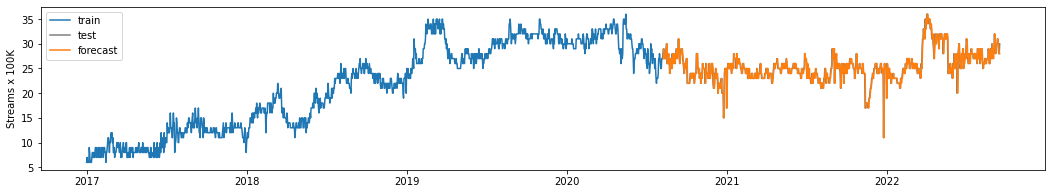

In [20]:
# plot the forecast
fig = plt.figure(figsize=(18,3))
plt.plot(train_df['streams'], color='C0', label='train')
plt.plot(test_df['streams'], color='C7', label='test')
plt.plot(forecast_df['streams'], color='C1', label='forecast')
plt.legend()
plt.ylabel("Streams x 100K")

start_date = np.datetime64('2021-05-11T00:00:00.000000000')
end_date = np.datetime64('2022-09-15T00:00:00.000000000')
#plt.xlim(start_date, end_date)


In [21]:
show_errors(test_df['streams'].values,forecast_df['streams'].values)

,RMSE,MAE,MAPE
0,1.582374,0.964844,3.957511


Modification: Previous-week (D-7) value

In [22]:
# shift the data 7 day to the right- Checking for day of week correlations
forecast_df = data.shift(7)[test_start_data_range:test_end_data_range]

Text(0, 0.5, 'Streams x 100K')

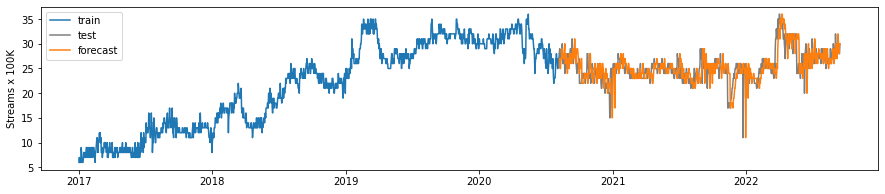

In [23]:
# plot the forecast
fig = plt.figure(figsize=(15,3))
plt.plot(train_df['streams'], color='C0', label='train')
plt.plot(test_df['streams'], color='C7', label='test')
plt.plot(forecast_df['streams'], color='C1', label='forecast')
plt.legend()
plt.ylabel("Streams x 100K")

In [24]:
show_errors(test_df['streams'],forecast_df['streams'])

,RMSE,MAE,MAPE
0,2.342986,1.635417,6.661818


### 2.2. Windowed Average Approach
The average over the X recent days is the forecast value

In [25]:
# To simulate a windowed forecast that takes in incoming data from test set
# use the pd.rolling grouper and pass the mean method
# and shift 1 day ahead to match target forecast date

#Set window to 7 days
forecast_df = data.rolling(7).mean().shift(1)[test_start_data_range:test_end_data_range]

Text(0, 0.5, 'Streams')

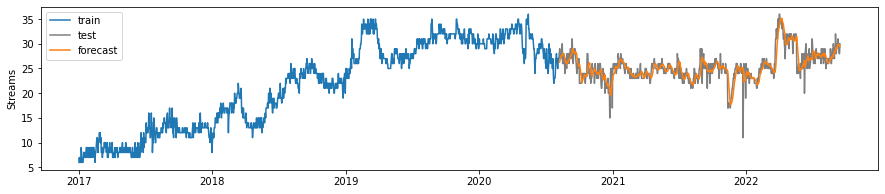

In [26]:
# plot the forecast
fig = plt.figure(figsize=(15,3))
plt.plot(train_df['streams'], color='C0', label='train')
plt.plot(test_df['streams'], color='C7', label='test')
plt.plot(forecast_df['streams'], color='C1', label='forecast')
plt.legend()
plt.ylabel("Streams")

In [27]:
show_errors(test_df['streams'],forecast_df['streams'])

,RMSE,MAE,MAPE
0,1.678049,1.171131,4.801431


### 2.3. Exponential Average Approach
The weighted average over the most recent days is the forecast value, where the weights are given by the following formula as set by a smoothing factor $\alpha$

![](https://miro.medium.com/max/1256/1*gzC8tdlwaLM3Y1tiaM3xzw.png)

 Larger $\alpha$ values will assign larger weights to more recent dates.

In [28]:
# To simulate an EMA  forecast that takes in incoming data from test set
# use the pd.rolling grouper and pass the mean method
# and shift 1 day ahead to match target forecast date

#Set window to 7 days
#Set alpha to 0.7, i.e. 70% of the forecast will come from the most recent data point

forecast_df = data.ewm(alpha=0.7).mean().shift(1)[test_start_data_range:test_end_data_range]

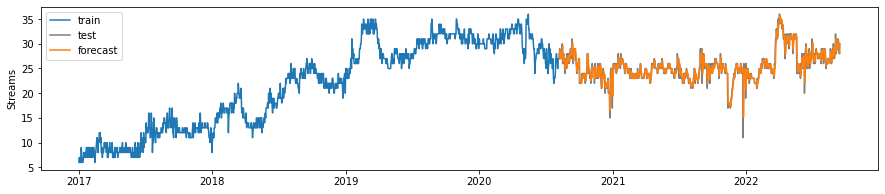

In [29]:
# plot the forecast
fig = plt.figure(figsize=(15,3))
plt.plot(train_df['streams'], color='C0', label='train')
plt.plot(test_df['streams'], color='C7', label='test')
plt.plot(forecast_df['streams'], color='C1', label='forecast')
plt.legend()
plt.ylabel("Streams")


start_date = np.datetime64('2022-05-11T00:00:00.000000000')
end_date = np.datetime64('2022-09-15T00:00:00.000000000')
#plt.xlim(start_date, end_date)


In [30]:
show_errors(test_df['streams'],forecast_df['streams'])

,RMSE,MAE,MAPE
0,1.496613,0.980007,4.022955


### 2.4. Trend and Seasonality Approaches 
One example of a forecasting method that takes trend and seasonality into account is the Holt-Winters method, which uses exponential averages over components. The **Holt-Winters seasonal method** comprises the forecast equation and three smoothing equations

![](https://cdn.analyticsvidhya.com/wp-content/uploads/2018/01/eq.png)

The method implemented in statsmodels automatically computes for the required parameters

In [31]:
from statsmodels.tsa.api import ExponentialSmoothing

We generate the forecast by calling the fitted model to generate values for every required timestep. 
For this example , we tune the model one-time, and only on the initial train data

In [32]:
# specify fit for weekly (d=7) seasonal cycles
# assume additive combinations of component
model_fit = ExponentialSmoothing(train_df['streams'],seasonal_periods=7 ,trend='add', seasonal='add').fit()
forecast_df = pd.DataFrame(model_fit.forecast(len(test_df)).values, index=test_df.index,\
                           columns=['streams']) 

In [33]:


start_date = np.datetime64('2022-05-11T00:00:00.000000000')
end_date = np.datetime64('2022-09-15T00:00:00.000000000')
#plt.xlim(start_date, end_date)

In [34]:
show_errors(test_df['streams'],forecast_df['streams'])

,RMSE,MAE,MAPE
0,8.846451,8.04874,32.923835


### 2.5. Stochastic Approaches
A popular and frequently used stochastic (i.e. probabilistic "randomness" based models) time series model is the ARIMA model. It assumes that the time-series is linear and follows a particular known statistical distribution, such as the normal distribution, and has subclass of other models such as the Autoregressive (AR) model, the Moving average (MA) model, and the Autoregressive Moving Average (ARMA) model of which the ARIMA model was based on. 

An *ARIMA model* is usually written as ARIMA (p,d,q) 

![](https://miro.medium.com/max/875/1*J1cOKMRU17nr71T-Xx6_HQ.png)

where: 

p = The order of the Autoregressive part of the model

d= The degree of first differencing in our model

q = The order of the Moving average part of the model

**How do we get the optimal values for these parameters?**

**p**: The PACF can be used to determine how many AR terms you need to use to explain the autocorrelation pattern in a time series: if the partial autocorrelation is significant at lag k and not significant at any higher order lags — i.e., if the PACF “cuts off” at lag k — then this suggests that you should try fitting an autoregressive model of order k

**q**: The ACF can be used to determine how many MA terms you need for a model. Another way to think about the moving average model is that it corrects future forecasts based on errors made on recent forecasts. We would expect the ACF for the MA(k) process to show a strong correlation with recent values up to the lag of k, then a sharp decline to low or no correlation. 

**d**: Used only when time series is not stationary. Usually d=1 or 2 is sufficient

In [35]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

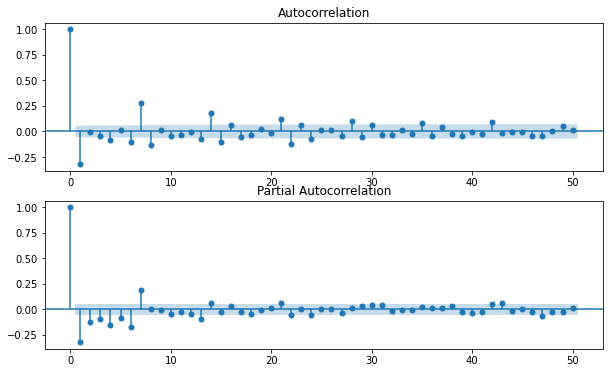

In [36]:
#PACF
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

acf = plot_acf(train_df['streams'].interpolate().diff()[1:], lags=50, ax=ax1)
pacf = plot_pacf(train_df['streams'].interpolate().diff()[1:], lags=50, ax=ax2)

From the ACF, it seems like the model needs to take in 7 MA terms (i.e. moving averages up to 7 days), i.e. q=7

From the PACF, it is likely that a model with up to 7 AR terms also would be best to use, i.e. p=7

We set d = 1 to stationarize the train set

In [37]:
train_df[["streams"]]

,streams
date,
2017-01-01,6
2017-01-02,7
2017-01-03,6
2017-01-04,6
2017-01-05,6
...,...
2020-08-04,25
2020-08-05,27
2020-08-06,27


In [38]:
#PACF, stationary, ACF

#train_df_=train_df
#train_df_.index = train_df_.index.asfreq('D')

#train_df_.index = pd.DatetimeIndex(train_df_.index).to_period('D')
model = ARIMA(train_df[["streams"]], order=(7, 1, 7))  
model_fit = model.fit() 
train_fit_df = pd.DataFrame(model_fit.fittedvalues, columns=['streams'])

Text(0, 0.5, 'Streams')

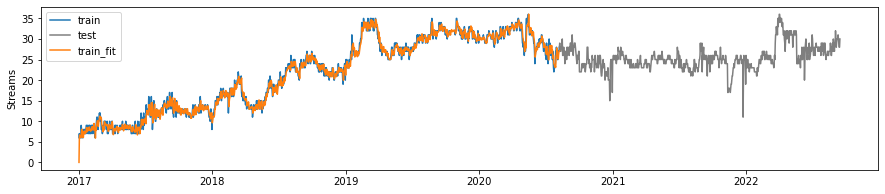

In [39]:
#plot the fitted training data
fig = plt.figure(figsize=(15,3))

#train_df_=
# test_df_=test_df
# train_fit_df_=train_fit_df


# train_df_.index = train_df_.index.to_timestamp()
# test_df_.index = test_df_.index.to_timestamp()
# train_fit_df_.index = train_fit_df_.index.to_timestamp()


plt.plot(train_df['streams'], color='C0', label='train')
plt.plot(test_df['streams'], color='C7', label='test')
plt.plot(train_fit_df['streams'], color='C1', label='train_fit')
plt.legend()
plt.ylabel("Streams")

In [40]:
train_df['streams'].index

DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
               '2017-01-09', '2017-01-10',
               ...
               '2020-07-30', '2020-07-31', '2020-08-01', '2020-08-02',
               '2020-08-03', '2020-08-04', '2020-08-05', '2020-08-06',
               '2020-08-07', '2020-08-08'],
              dtype='datetime64[ns]', name='date', length=1313, freq=None)

We generate the forecast by calling the fitted model to generate values for every required timestep. 
For this example , we tune the model one-time, and only on the initial train data

In [41]:
#dynamic = True toggles use of preceding forecast value with the model fit values to get the next forecast value
forecast_df = pd.DataFrame(model_fit.forecast(len(test_df),dynamic=True).values, index=test_df.index,\
                           columns=['streams'])

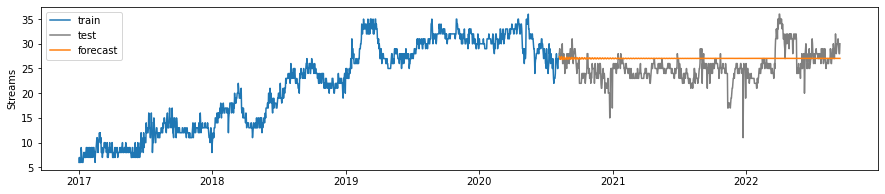

In [42]:
#plot the fitted training data
fig = plt.figure(figsize=(15,3))

plt.plot(train_df['streams'], color='C0', label='train')
plt.plot(test_df['streams'], color='C7', label='test')
plt.plot(forecast_df['streams'], color='C1', label='forecast')
plt.legend()
plt.ylabel("Streams")



start_date = np.datetime64('2020-05-11T00:00:00.000000000')
end_date = np.datetime64('2020-09-15T00:00:00.000000000')
#plt.xlim(start_date, end_date)

In [43]:
forecast_df

,streams
date,
2020-08-08,27.425670
2020-08-09,27.082965
2020-08-10,26.851143
2020-08-11,27.020891
2020-08-12,26.868563
...,...
2022-09-11,27.044034
2022-09-12,27.043679
2022-09-13,27.043127


In [44]:
show_errors(test_df['streams'],forecast_df['streams'])

,RMSE,MAE,MAPE
0,3.358795,2.720889,11.351912


# Function

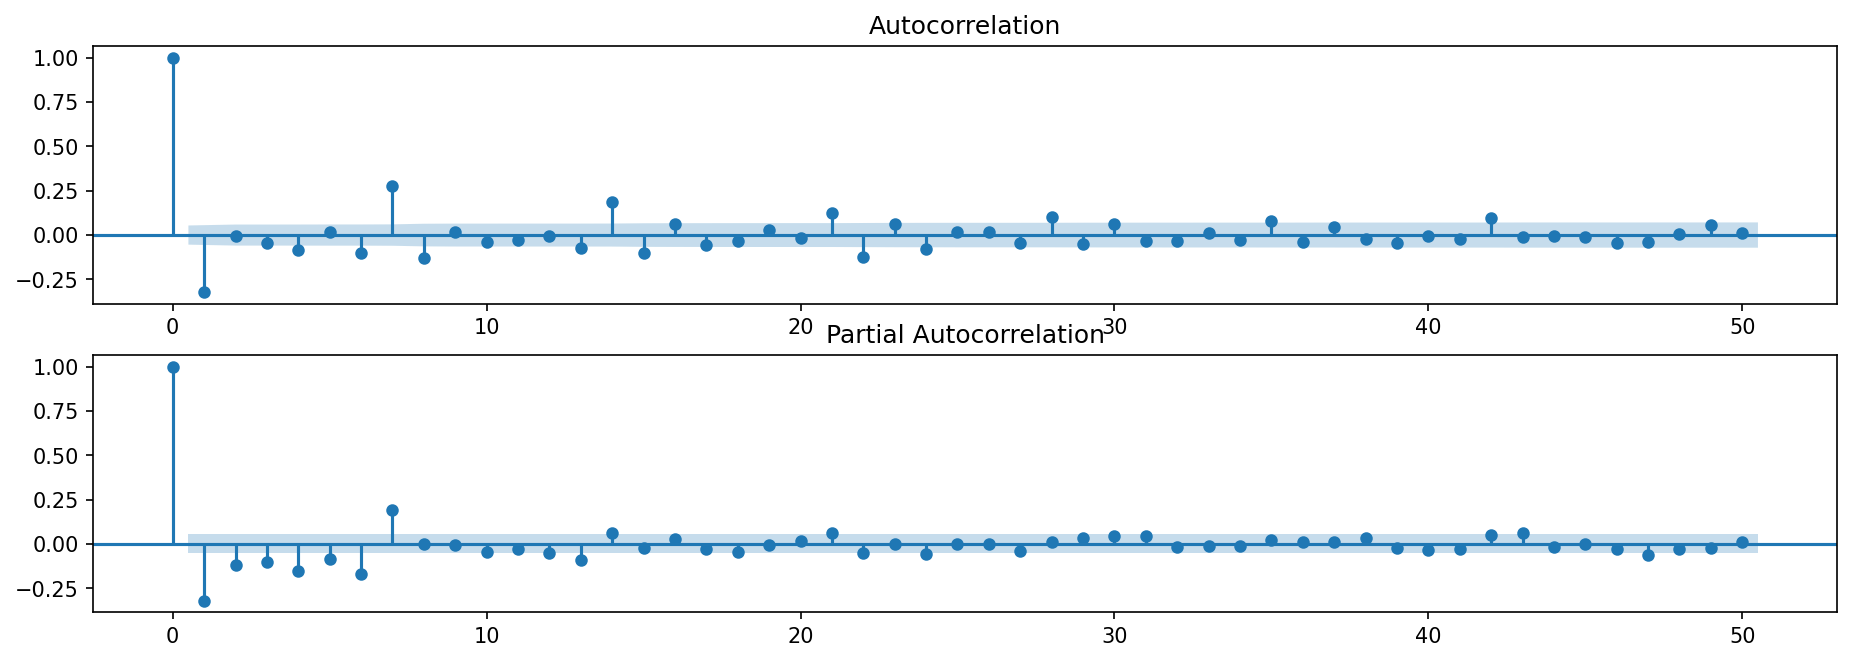

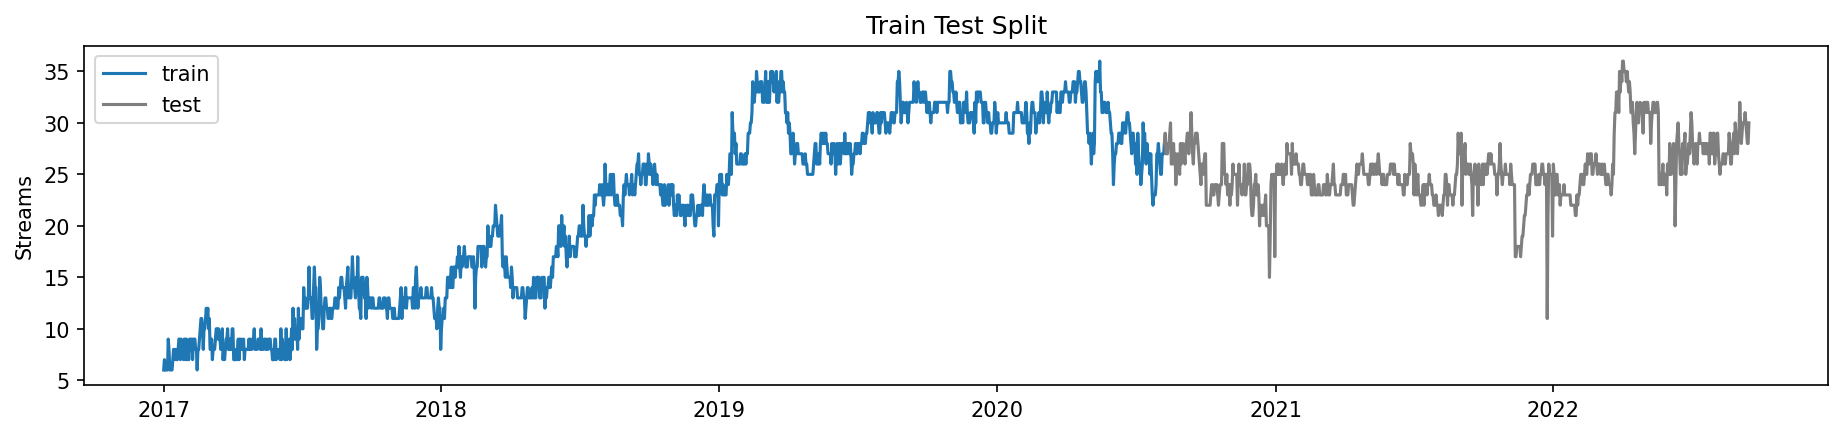

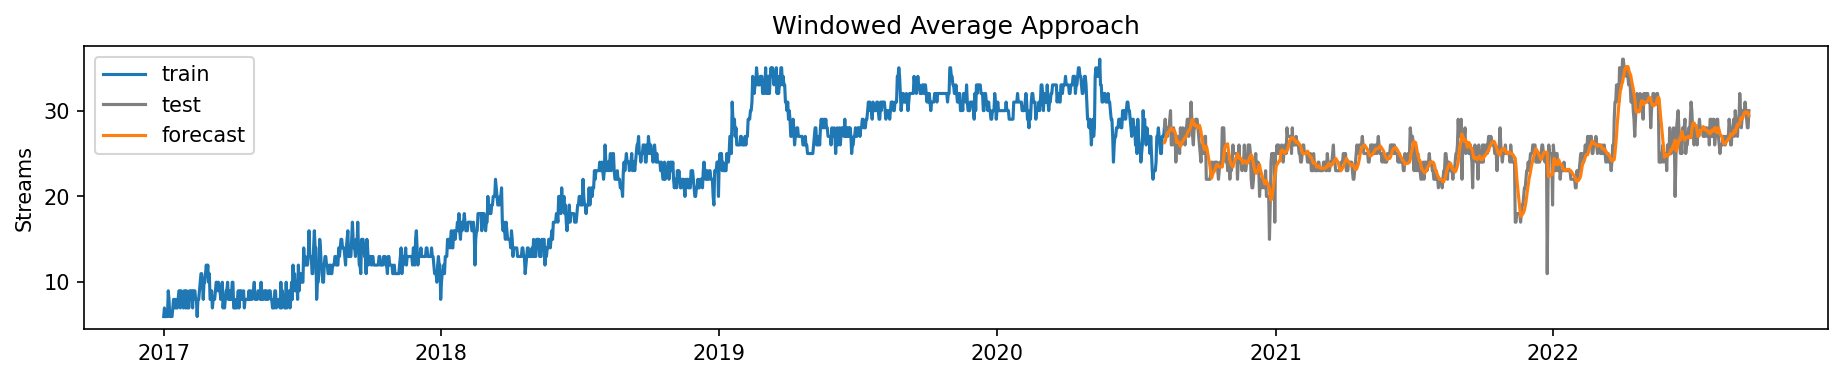

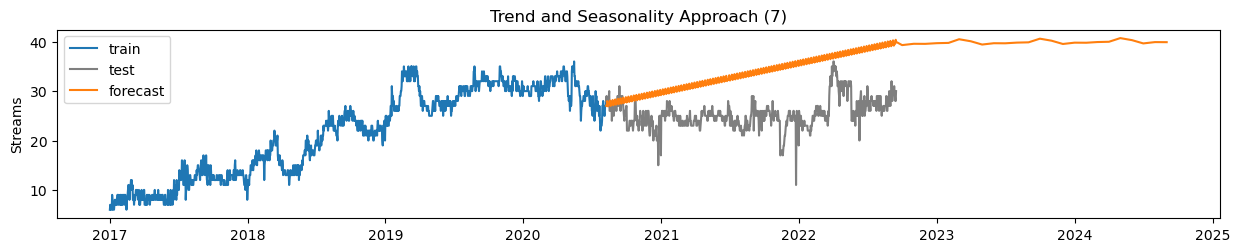

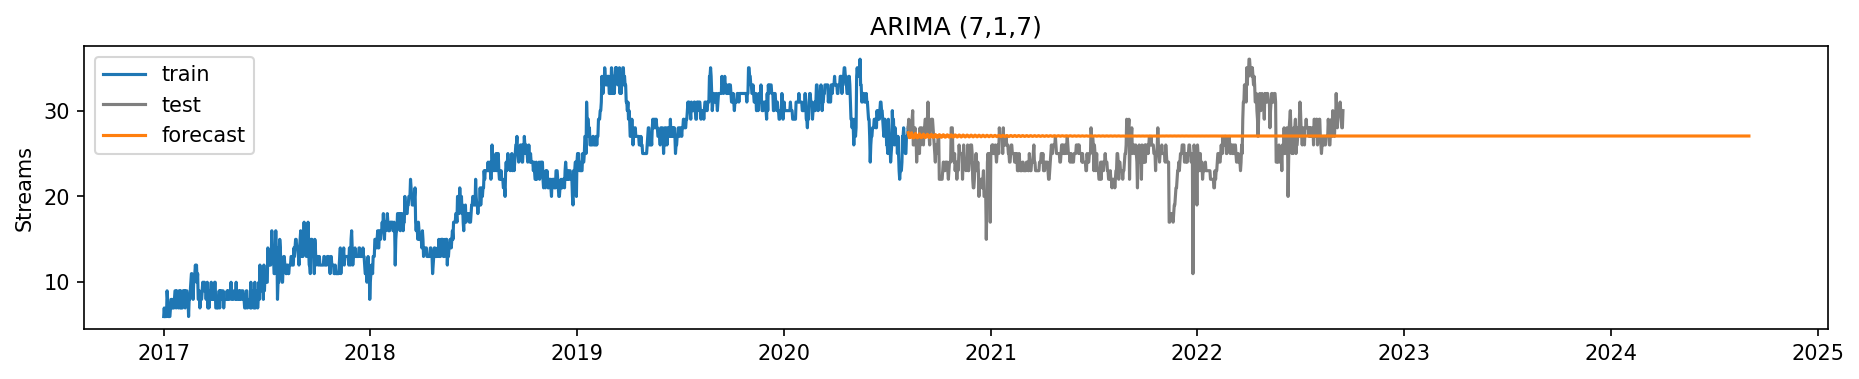

In [45]:
import warnings
    
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pickle
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.api import ExponentialSmoothing



def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred): 
    return np.sqrt(mean_squared_error(y_true, y_pred))

def show_errors(y_true, y_pred):
    return pd.DataFrame({'RMSE': root_mean_squared_error(y_true,y_pred),\
                                            'MAE':mean_absolute_error(y_true,y_pred),\
                                            'MAPE': mean_absolute_percentage_error(y_true,y_pred)}, index=[0])



def plot(spec_genre):
    spec_dpi=150
    genre_groups = pickle.load(open('data/genre_groups.pkl', "rb"))
    genre_groups.groupby(['predicted_genre'])[["OPM"]].sum().sort_values(by='OPM',ascending=False)
    #spec_genre="opm rock"

    data=genre_groups[genre_groups.predicted_genre==spec_genre]
    #data.date.values.min(),data.date.values.max()
    data.set_index("date",inplace=True)
    data.columns=["predicted_genre","streams"]
    
    train_start_date_range='2017-01-01'
    train_end_date_range='2020-08-08'
    test_start_data_range='2020-08-08'
    test_end_data_range='2022-09-15'
    
    forward_test_end_data_range='2024-09-15'
    
    train_df = data[train_start_date_range:train_end_date_range]
    test_df = data[test_start_data_range:test_end_data_range]
    
    #data_=data.copy()
    last_date = data.index[-1]
    last_streams = data.streams[-1]

    # Generate a sequence of dates for 2 years starting from the last date
    new_dates = pd.date_range(start=last_date, periods=24*12, freq='MS')

    # Create a new DataFrame with the new dates and fill with zeros
    new_data = pd.DataFrame(last_streams, index=new_dates, columns=data.columns)
    
    # Concatenate the existing data and the new data
    data_ = pd.concat([data, new_data])
                            
    forward_test_df = data_[test_start_data_range:forward_test_end_data_range]
    #display(forward_test_df)
    
    train_df_ = train_df.copy()
    test_df_ =  test_df.copy()
    forward_test_df_=forward_test_df.copy()
    train_df_.index = pd.DatetimeIndex(train_df.index).to_period('D')
    test_df_.index = pd.DatetimeIndex(test_df.index).to_period('D')
    forward_test_df_.index = pd.DatetimeIndex(forward_test_df.index).to_period('D')
    
    
    
    #PACF
    #print("ACF and PACF")
    fig = plt.figure(figsize=(15,5),dpi=spec_dpi)
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)

    acf = plot_acf(train_df['streams'].interpolate().diff()[1:], lags=50, ax=ax1)
    pacf = plot_pacf(train_df['streams'].interpolate().diff()[1:], lags=50, ax=ax2)
    
    
    
    fig = plt.figure(figsize=(15,3),dpi=spec_dpi)
    plt.plot(train_df['streams'], color='C0', label='train')
    plt.plot(test_df['streams'], color='C7', label='test')
    plt.legend()
    plt.ylabel("Streams")
    #print("Train Test Split")
    plt.title("Train Test Split")
    plt.show()
    
    #print("")
    #print("Windowed Average Approach")
    forecast_df = data.rolling(7).mean().shift(1)[test_start_data_range:test_end_data_range]
    # plot the forecast
    fig = plt.figure(figsize=(15,2.5),dpi=spec_dpi)
    plt.plot(train_df['streams'], color='C0', label='train')
    plt.plot(test_df['streams'], color='C7', label='test')
    plt.plot(forecast_df['streams'], color='C1', label='forecast')
    plt.legend()
    plt.ylabel("Streams")
    plt.title("Windowed Average Approach")
    plt.show()
    
    print("")
    #print("Trend and Seasonality Approach")
    
    model_fit = ExponentialSmoothing(train_df_['streams'],seasonal_periods=7 ,trend='add', seasonal='add').fit()
    forecast_df = pd.DataFrame(model_fit.forecast(len(forward_test_df_)).values, index=forward_test_df_.index,\
                               columns=['streams']) 
    #display(forecast_df)


    #plot the fitted training data
    fig = plt.figure(figsize=(15,2.5),dpi=100)

    plt.plot(train_df['streams'], color='C0', label='train')
    plt.plot(test_df['streams'], color='C7', label='test')
    plt.plot(forecast_df['streams'], color='C1', label='forecast')
    plt.legend()
    plt.ylabel("Streams")
    plt.title("Trend and Seasonality Approach (7)")
    plt.show()


    print("")
    #print("ARIMA")
    model = ARIMA(train_df_[["streams"]], order=(7, 1, 7))  
    model_fit = model.fit() 
    train_fit_df = pd.DataFrame(model_fit.fittedvalues, columns=['streams'])
    forecast_df = pd.DataFrame(model_fit.forecast(len(forward_test_df_),dynamic=True).values, index=forward_test_df_.index,\
                               columns=['streams'])
    #plot the fitted training data
    fig = plt.figure(figsize=(15,2.5),dpi=spec_dpi)

    plt.plot(train_df['streams'], color='C0', label='train')
    plt.plot(test_df['streams'], color='C7', label='test')
    plt.plot(forecast_df['streams'], color='C1', label='forecast')
    plt.legend()
    plt.ylabel("Streams")
    plt.title("ARIMA (7,1,7)")
    plt.show()
    
plot("opm rock")